# Notebook ideas
- csv
    - the user will input what graph and which versions will be tested through a csv file
    - csv structure:
        - file name, graph version, ontology
- run live
    - user settings: 
        - endpoint
        - csv file
        - graph name
- visualize live

# TODO:
- Set common scale on axis that could be missleading

# README

# Imports

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import visualizer as viz
import queries as que
import pywikibot
from SPARQLWrapper import SPARQLWrapper, CSV, JSON

In [7]:
endpoint = 'http://localhost:8890/sparql'
graph_csv = pd.read_csv('Data/notebook.csv')
graph_list = list(graph_csv.File.values)
version_list = (list(graph_csv.Version.values))
ont_list = list(graph_csv.Ont.values)
graph_name = 'Test Graph'

In [8]:
# Configure the SPARQL endpoint
sparql = SPARQLWrapper(endpoint)

# Configure the SPARQL endpoint and desired return format
sparql.setReturnFormat(JSON)

# Get basics

In [9]:
que.data_info(sparql, graph_list)

http://localhost:8890/dims completed
http://localhost:8890/35 completed


# Get structure and content

In [10]:
struc_cont = que.structure_and_content(sparql, [graph_list])

{'File': ['http://localhost:8890/dims'], 'Version': [0], 'Density': [0.000128171], 'CC': [0], 'KD': [1.94609], 'VocUni': [0.841084], 'Vdyn': [0], 'AddVdyn': [0], 'RemVdyn': [0], 'ChangeRatio': [0], 'AddCR': [0], 'RemCR': [0], 'Growth': [0]}
Doing comparisons of http://localhost:8890/dims and  http://localhost:8890/35
Starting queries
Enumerator: 8777
Denominator: 8790.0
Vdyn: 0.9985210466439135
{'File': ['http://localhost:8890/dims', 'http://localhost:8890/35'], 'Version': [0, 1], 'Density': [0.000128171, 0.00669425], 'CC': [0, 0], 'KD': [1.94609, 2.58398], 'VocUni': [0.841084, 0.388], 'Vdyn': [0, 0.9985210466439135], 'AddVdyn': [0, 0.04391353811149033], 'RemVdyn': [0, 0.9546075085324232], 'ChangeRatio': [0, 1.00064], 'AddCR': [0, 0.10001], 'RemCR': [0, 1.0], 'Growth': [0, 0.10001]}


In [11]:
struc_cont_data = pd.read_csv('structure_and_content.csv')

# Get quality

In [12]:
quality = que.quality(sparql, graph_list, ont_list)

{'File': ['http://localhost:8890/dims'], 'Version': [0], 'ICR': [0.0], 'IPR': [0.0], 'IMI': [1.0]}
{'File': ['http://localhost:8890/dims', 'http://localhost:8890/35'], 'Version': [0, 1], 'ICR': [0.0, 0.309804], 'IPR': [0.0, 0.0], 'IMI': [1.0, 1.0]}


In [13]:
quality_data = pd.read_csv('quality.csv')

# Get ipr and icr

In [14]:
que.ipcr_csv(sparql, graph_list, version_list, ont_list, name= 'ipr')
que.ipcr_csv(sparql, graph_list, version_list, ont_list, name= 'icr')

ipr
icr


# Load data

In [15]:
if False:
    file_path = 'Data/struct4.csv'
    data = viz.get_data(file_path= file_path)
    dbpedia_data = data[0]
    wiki_data = data[1]

# Top K most common

In [16]:
common_dict = que.top_entities(
    's', 
    wrapper= sparql, 
    graph_list= [graph_list],
    file_name= 'NotebookOutput/top_sub_.csv')

common_dict = que.top_entities(
    'p', 
    wrapper= sparql, 
    graph_list= [graph_list],
    file_name= 'NotebookOutput/top_pre_.csv')

common_dict = que.top_entities(
    'o', 
    wrapper= sparql, 
    graph_list= [graph_list],
    file_name= 'NotebookOutput/top_obj_.csv')

Please make sure that there are atleast 3 unique predicates


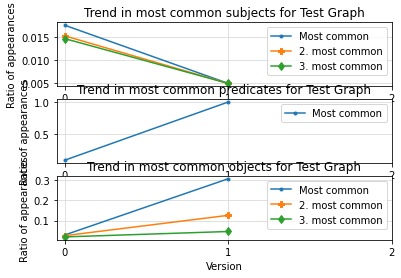

In [17]:
plt.rcParams["figure.figsize"] = [18, 15]
plt.subplot(3,1,1)
viz.top_trends('NotebookOutput/top_sub_.csv', 'basics.csv', graph_name, 'subjects', loc= 'upper right')
plt.subplot(3,1,2)
viz.top_trends('NotebookOutput/top_pre_.csv', 'basics.csv', graph_name, 'predicates', loc= 'upper right')
plt.subplot(3,1,3)
viz.top_trends('NotebookOutput/top_obj_.csv', 'basics.csv', graph_name, 'objects', loc= 'upper right')
plt.show()

# Structural measures of evolution

## Growth ratio

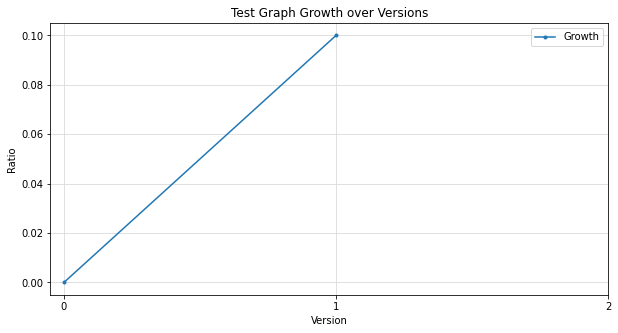

In [18]:
plt.rcParams["figure.figsize"] = [10, 5]
viz.plot_parameters_over_versions(struc_cont_data, ['Growth'], ['.'], f"{graph_name} Growth over Versions", output_file_name= '')

## Density

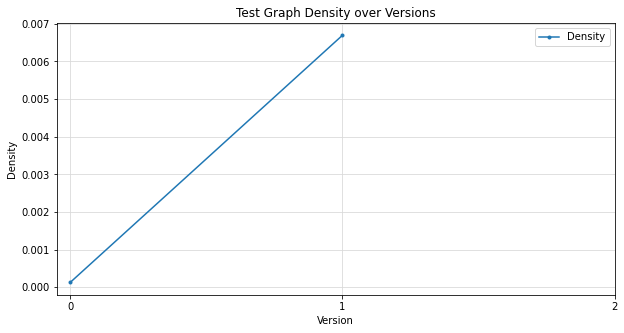

In [19]:
viz.plot_parameters_over_versions(
    struc_cont_data, ['Density'], ['.'], 
    f"{graph_name} Density over Versions", 
    output_file_name= '', y_label= 'Density')

# Measuring evolution of content

## Knowledge degree

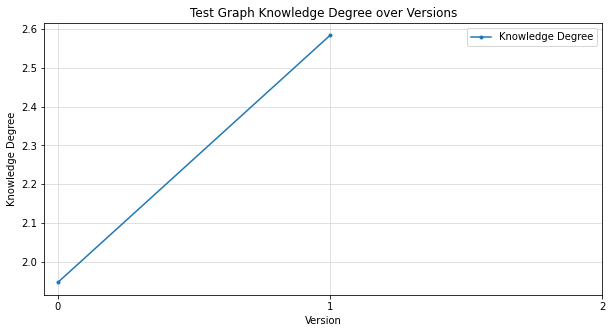

In [20]:
viz.plot_parameters_over_versions(
    struc_cont_data, ['KD'], ['.'], 
    f"{graph_name} Knowledge Degree over Versions", 
    output_file_name= '', y_label= 'Knowledge Degree')

## Change ratio

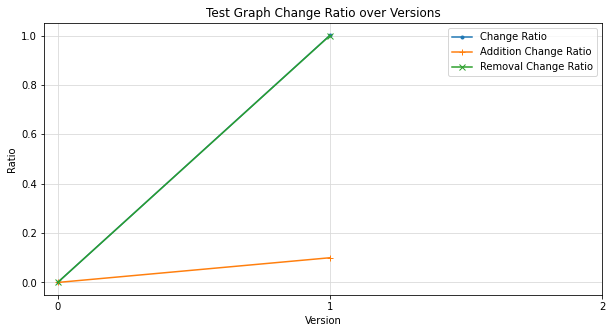

In [21]:
viz.plot_parameters_over_versions(
    struc_cont_data, ['ChangeRatio', 'AddCR', 'RemCR'], ['.', '+', 'x'], 
    f"{graph_name} Change Ratio over Versions", 
    output_file_name= '')

## Vocabulary

### Vocabulary uniqueness

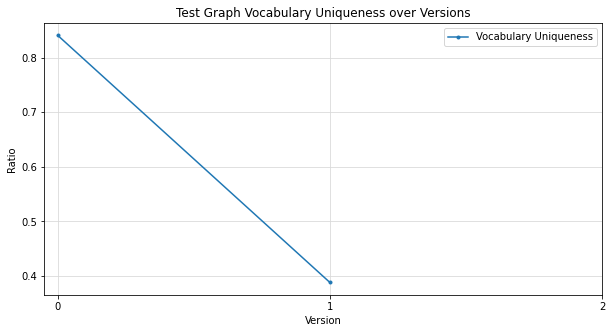

In [22]:
viz.plot_parameters_over_versions(
    struc_cont_data, ['VocUni'], ['.'], 
    f"{graph_name} Vocabulary Uniqueness over Versions", 
    output_file_name= '')

### Vocabulary dynamicity

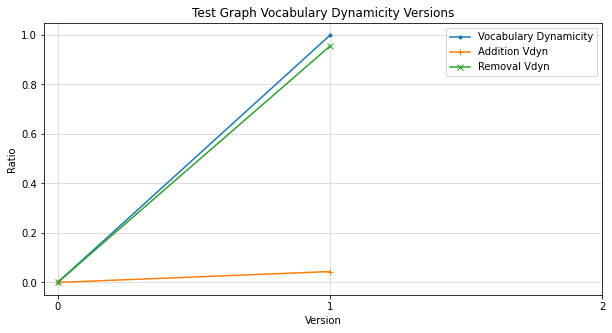

In [23]:
viz.plot_parameters_over_versions(
    struc_cont_data, ['Vdyn', 'AddVdyn', 'RemVdyn'], ['.', '+', 'x'], 
    f"{graph_name} Vocabulary Dynamicity Versions", 
    output_file_name= '')

# Measuring quality between versions
- Instantiated class ratio
- Instantiated property ratio
- Inverse multiple inheritance number

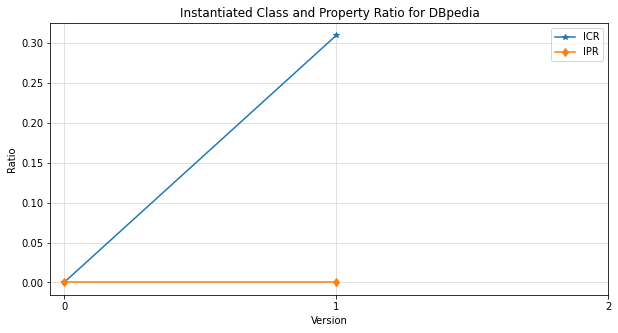

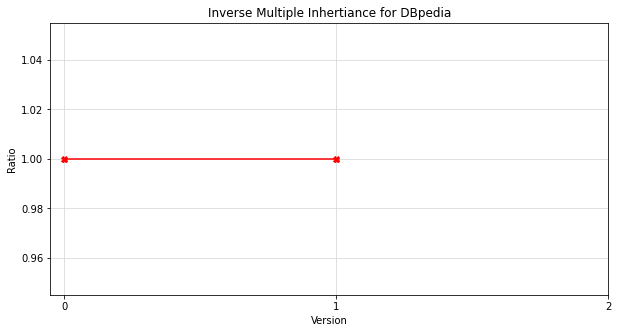

In [24]:
viz.quality_plots(file_path= 'quality.csv')

## Class growth for DBpedia

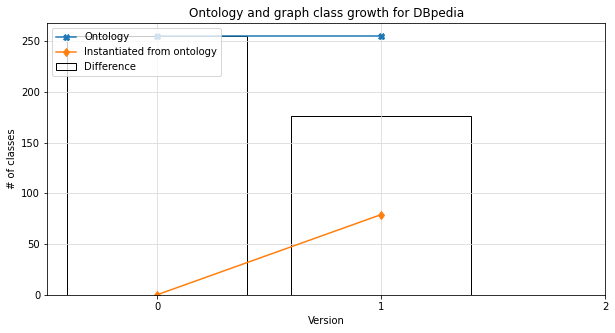

In [29]:
plt.rcParams["figure.figsize"] = [10, 5]
viz.ont_growth(file_path= 'icr.csv', title_name= 'class')

## Property growth for DBpedia

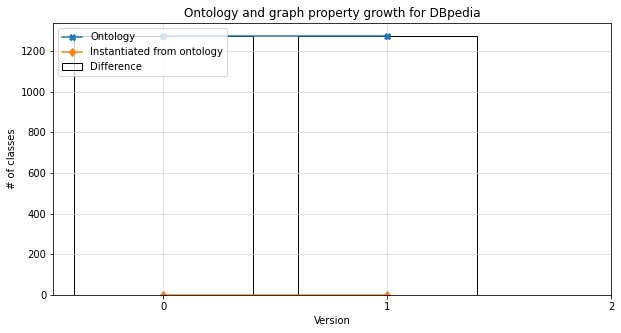

In [30]:
plt.rcParams["figure.figsize"] = [10, 5]
viz.ont_growth(file_path= 'ipr.csv', title_name= 'property')

## Use of external vs. internal classes

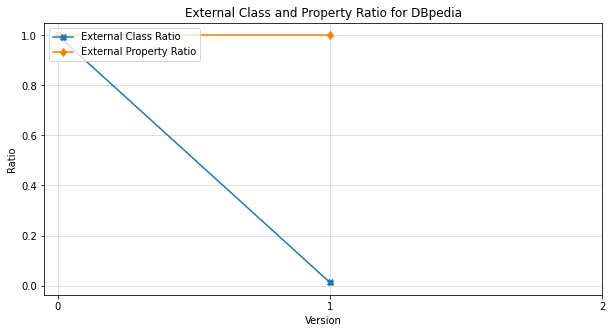

In [31]:
plt.rcParams["figure.figsize"] = [10, 5]
viz.external_ratio(class_path= 'icr.csv', property_path= 'ipr.csv')